# Module 2 Final Project Submission - Question 2 of 4

* Student name: **Chelsea Power**
* Student pace: **part time**
* Scheduled project review date/time: **May 10, 2019 at 3:30 pm ET**
* Instructor name: **Joe San Pietro**
* Blog post URL: **TBD**

### Question 2: Does the revenue per order vary by different regions?

In [1]:
# Import required libraries
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Connect an engine and connect to the Northwind database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)

# Create session to execute SQL commands
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

# Extract data required as a pandas dataframe using a SQL query
df2 = pd.read_sql_query('''
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order"
 ON Customer.Id
 LEFT JOIN OrderDetail
 ON OrderID
 ''', engine)

2019-05-10 13:19:36,995 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-10 13:19:36,996 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 13:19:36,996 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-10 13:19:36,997 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 13:19:36,998 INFO sqlalchemy.engine.base.Engine 
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order"
 ON Customer.Id
 LEFT JOIN OrderDetail
 ON OrderID
 
2019-05-10 13:19:36,999 INFO sqlalchemy.engine.base.Engine ()


In [2]:
# Display dataframe
df2.head()

,Region,Quantity,OrderId,UnitPrice,Discount
0,Western Europe,12,10248,14.0,0.0
1,Western Europe,10,10248,9.8,0.0
2,Western Europe,5,10248,34.8,0.0
3,Western Europe,9,10249,18.6,0.0
4,Western Europe,40,10249,42.4,0.0


In [5]:
# Calculate the revenue per order
df2['price_per_order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

# Drop columns for quantity, unit price and discount now that we have the total revenue
df2.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Group data by order and add the revenue for each order
df2 = df2.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()

# Drop OrderId - no longer need this
df2.drop('OrderId', axis=1, inplace=True)

In [6]:
# Display dataframe of price per order by region
df2.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [7]:
# Group dataframe by region and show count of orders per region
df2.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


In [9]:
# Combine Eastern and Southern Europe
df2.loc[(df.Region == 'Eastern Europe') | (df2.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combine Scandinavia and Northern Europe
df2.loc[(df.Region == 'Scandinavia') | (df2.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combine Central and South America
df2.loc[(df.Region == 'Central America') | (df2.Region == 'South America'),'Region'] = 'South and Central America'

In [10]:
# Group dataframe by region and show count - confirm region size
df2.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


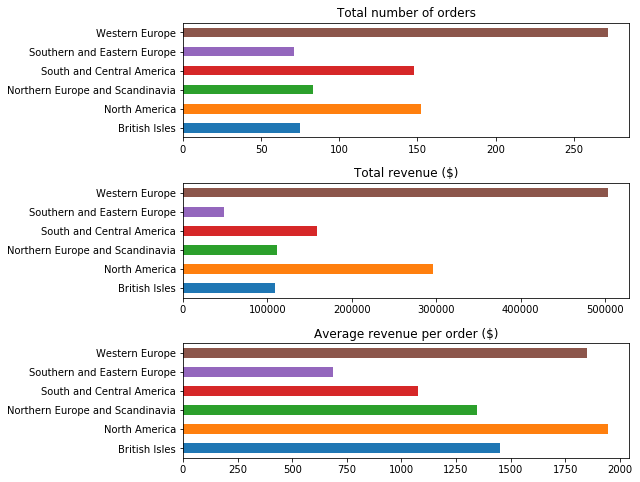

In [12]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
df2.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df2.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
df2.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


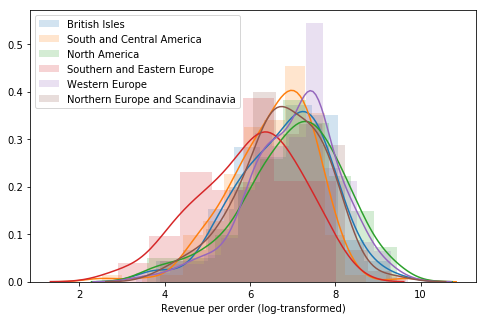

In [15]:
# Copy dataset and log-transforming price_per_order
df2_log = df2.copy()
df2_log['price_per_order'] = np.log(df2['price_per_order'])

# Plot log-transformed data
plt.figure(figsize=(8,5))
for region in set(df2_log.Region):
    region_group = df2_log.loc[df_log['Region'] == region]
    sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Revenue per order (log-transformed)')

In [16]:
# Fit the model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Region)', df2_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN
